In [1]:
# !python -m pip install "gymnasium[atari]"
# !python -m pip install "gymnasium[accept-rom-license, atari]"
# !pip install shimmy

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
import numpy as np

import ale_py
import shimmy
import joblib
import os

from gym import wrappers

| **Value** | **Meaning** |
|:---------:|:-----------:|
| 0 | NOOP |
| 1 | FIRE |
| 2 | RIGHT |
| 3 | LEFT |
| 4 | RIGHTFIRE |
| 5 | LEFTFIRE |

# General Functions

In [3]:
def show_obs(obs):
    plt.figure(figsize=(16,10))
    plt.imshow(obs)
    plt.show()
    return

# Policy Functions

In [4]:
def discount_rewards(r):
    """ 
    take 1D float array of rewards and compute discounted reward
    this function discounts from the action closest to the end of the completed game backwards
    so that the most recent action has a greater weight 
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

# Run Constants

In [5]:
batch_size = 64 # used to perform a RMS prop param update every batch_size steps
learning_rate = 1e-2 # learning rate used in RMS prop
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2

# Config flags - video output and res
resume = True # resume training from previous checkpoint (from save.p  file)?
render = False # render video output?
print_ = False # print each observation
show = False
zero_grad = True
corner_correct = True

timer_i = 1000

record_probs = True
record_rewards = True
record_eps_iters = True
save_path = '32n_model.joblib'

# Model Instantiation

In [6]:
OBS_SHAPE = (210, 160)
XMIN = 26
XMAX = 196
YMIN = 14
YMAX = 144
SHAPE = (XMAX - XMIN, YMAX - YMIN)
DOWNSAMPLE = False
DIM = np.prod(SHAPE) // 4 if DOWNSAMPLE else np.prod(SHAPE)

ACTIONS = [0,1,2,3,4,5] # modify to limit actions
N_CLASSES = len(ACTIONS)

print('Input Shape:', SHAPE)
print('Input Dimensionality:', DIM)

def preprocess(obs, downsample=True, xmin=26, xmax=196, ymin=10, ymax=144):
    assert obs.shape == (210, 160)
    I = obs[xmin:xmax,ymin:ymax] # crop - remove 35px from start & 25px from end of image in x, to reduce redundant parts of image (i.e. after ball passes paddle)
    if downsample:
        I = I[::2,:]
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else to 1
    return I.astype(np.float32).ravel() # ravel flattens an array and collapses it into a column vector

def max_pool(input_image, pool_size=2, stride=2):
    assert input_image.ndim == 2
    output_shape = ((input_image.shape[0] - pool_size) // stride) + 1
    
    # Create an empty output array
    output_image = np.zeros((output_shape, output_shape))
    
    # Loop through the input image and apply the max pooling operation
    for i in range(0, input_image.shape[0] - pool_size + 1, stride):
        for j in range(0, input_image.shape[1] - pool_size + 1, stride):
            output_image[i // stride, j // stride] = np.max(input_image[i:i+pool_size, j:j+pool_size])
    
    return output_image

Input Shape: (170, 130)
Input Dimensionality: 22100


# Layers

In [7]:
def standardize(arr):
    arr -= np.mean(arr)
    arr /= np.std(arr)
    return arr

def lrelu(x, alpha=.03):
    x[x < 0] *= alpha
    return
    
def dropout(x, frac=.2):
    if frac:
        drop_indices = np.random.choice(x.shape[0], size=x.shape[0]*frac)
        x[drop_indices] = 0
    return

def softmax(x):
    x_exp = np.exp(x - np.max(x))
    x_sum = np.sum(x_exp)
    x_softmax = np.divide(x_exp, x_sum) #normalize
    assert round(np.sum(x_softmax), 5) == 1, x_softmax
    return x_softmax

## Three Layer Network
- Single hidden layer + input/output layers
- Leaky Relu

In [8]:
def triple_layer(n_neurons=64, n_classes=6, dim=6000):
    middle_n = n_neurons // 2
    model = {
        'Layer1' : np.random.randn(n_neurons, middle_n) / np.sqrt(middle_n),
        'Layer2' : np.random.randn(middle_n, dim) / np.sqrt(dim),
        'Layer3' : np.random.standard_normal((n_classes, n_neurons)) / np.sqrt(n_neurons),
    }
    return model
   
def policy_triple_forward(x, alpha=.03, frac=.2):
    x = np.dot(model['Layer1'], x)
    lrelu(x, alpha=alpha)
    dropout(x, frac=frac)

    alpha /= 2
    frac /= 2
    
    x = np.dot(model['Layer2'], x)
    lrelu(x, alpha=alpha)
    dropout(x, frac=frac)
    
    logp = np.dot(model['Layer3'], x)
    p = softmax(logp)
    return p, x

def policy_triple_backward(eph, epx, epdlogp):
    dl3 = np.dot(eph.transpose(), epdlogp).ravel()
    dx = np.outer(epdlogp, model['Layer3'])
    dx[eph <= 0] = 0
    
    dl2 = np.outer(dx, model['Layer2'])
    dh[eph <= 0] = 0
    
    dW1 = np.dot(dh.transpose(), epx)
    model = {
        'Layer1' : dl1, 
        'Layer2' : dl2, 
        'Layer3' : dl3,
    }
    return model

## Two Layer Network
- Input and output layers
- relu

In [9]:
def network():
    model = {
        'W1' : np.random.randn(N_NEURONS,DIM) / np.sqrt(DIM),
        'W2' : np.random.standard_normal((N_CLASSES, N_NEURONS)) / np.sqrt(N_NEURONS),
    }
    return model

def policy_forward(x, alpha=.03):
    h = np.dot(model['W1'], x)
    leaky_relu(h, alpha=alpha)
    logp = np.dot(model['W2'], h)
    probs = softmax(logp)
    return probs, h

def policy_backward(eph, epx, epdlogp):
    dW2 = np.dot(eph.transpose(), epdlogp).transpose()
    dh = np.dot(epdlogp, model['W2'])
    
    dh[eph < 0] = 0
    dW1 = np.dot(dh.transpose(), epx)
    model = {
        'W1' : dW1,
        'W2' : dW2,
    }
    return model

In [10]:
if resume and os.path.exists(save_path):
    model = joblib.load(save_path)
else:
    model = network()

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() }
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

In [11]:
prev_x = None # used in computing the difference frame
xs, hs, dlogps, drs = list(), list(), list(), list()
running_reward = None

reward_sum = 0
adj_reward_sum = 0

In [12]:
def add_noise(probs, i, i_since_r, timer_i, buffer=None, print_=False):
    if buffer is None:
        buffer = timer_i // 2
    n = len(probs)
    sigma = 2 / n
    noise = np.random.normal(0, sigma, size=n)
    noise = noise - np.mean(noise)
    
    scale = i_since_r / (timer_i - buffer)
    noise = noise * scale
    assert not round(np.mean(noise), 3), noise
    if print_ and not i % 100:
        print(probs)
        print(noise)
    new_probs = probs + noise
    pmin = np.amin(new_probs)
    if pmin < 0:
        new_probs -= pmin
        new_probs /= np.sum(new_probs)
    return new_probs

def balance_lr(probs, i_since_r, timer_i, buffer=None):
#    ACTIONS = [NOOP,1,2,3,4,5]
    if i_since_r < timer_i // 4:
        pass
    elif i_since_r < timer_i // 2:
        equal_n = (probs[2] + probs[3]) / 2
        equal_y = (probs[4] + probs[5]) / 2
        probs[2] = equal_n
        probs[3] = equal_n
        probs[4] = equal_y
        probs[5] = equal_y
    elif i_since_r < 3 * timer_i // 4:
        probs[2], probs[3] = probs[3], probs[2]
        probs[4], probs[5] = probs[5], probs[4]
    return probs
    
def modify_reward(action, reward, info, prev_lives):
    if info['lives'] < prev_lives:
        reward -= 15
    if reward <= 0 and action in [1,4,5]:
        reward -= 1
    return reward

In [13]:
n_episodes = 1
last_i = 0
env = gym.make(
    'ALE/DemonAttack-v5', 
    obs_type='grayscale', 
    render_mode='human' if render else None, 
)
        
if record_rewards:
    reward_list = list()
if record_probs:
    prob_list = list()
if record_eps_iters:
    eps_iters_list = list()

obs, info = env.reset()

episode_number = 0
prev_lives = 0
i = 0
# for i in range(int(iters)):
while episode_number <= n_episodes:
#     if render: 
#         env.render()
    ####################################################
    curr_x = preprocess(obs, downsample=DOWNSAMPLE, xmin=XMIN, xmax=XMAX, ymin=YMIN, ymax=YMAX)
    x = curr_x - prev_x if prev_x is not None else np.zeros(DIM)
    prev_x = curr_x

    # forward the policy network and sample an action from the returned probability
    probs, h = policy_forward(x)
    
    i_since_r = i - last_i
    if i_since_r > timer_i:
        terminated = True
        truncated = False
        print('Timer causing reset               ')
        last_i = i
    ##
    xs.append(x) # observation
    hs.append(h) # hidden state

    if corner_correct:
        probs = add_noise(probs, i, i_since_r, timer_i)
        probs = balance_lr(probs, i_since_r, timer_i)
    try:
        action = np.random.choice(ACTIONS, p=probs) # RANDOMLY choose one with probability weight based on forward pass expectations
    except Exception as e:
        print(probs)
        raise(e)
        
    if record_probs:
        prob_list.append(probs)

    y = np.zeros(N_CLASSES)
    y[ACTIONS.index(action)] = 1
    dlogps.append(y - probs) 
    
    #####################################################
    prev_lives = info['lives']
    obs, reward, terminated, truncated, info = env.step(action)
    if reward > 0:
        last_i = i

    reward_sum += reward
    adj_reward = modify_reward(action, reward, info, prev_lives)
    adj_reward_sum += adj_reward
    drs.append(adj_reward) # record reward (has to be done after we call step() to get reward for previous action)
    ######################################################

    if terminated: # an episode finished
        if record_rewards:
            reward_list.append(reward_sum)

        episode_number += 1
        if record_eps_iters:
            eps_iters_list.append(i)
#         print(f'Episode: {episode_number}              ')
        
        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        if not zero_grad:
            epx = np.vstack(xs)
            eph = np.vstack(hs)
            epdlogp = np.vstack(dlogps)
            epr = np.vstack(drs)
            for lis in [xs, hs, dlogps, drs]:
                lis.clear()

            
            discounted_epr = discount_rewards(epr)
            # standardize the rewards to be unit normal (helps control the gradient estimator variance)
            
            discounted_epr = standardize(discounted_epr)
            epdlogp *= discounted_epr # modulate the gradient with advantage (Policy Grad magic happens right here.)

            grad = policy_backward(eph, epx, epdlogp)
#             print([v.shape for v in grad.values()])
            for k in model:
#                 print(k)
#                 print('Buffer', grad_buffer[k].shape)
#                 print('Grad', grad[k].shape)
                grad_buffer[k] += grad[k] # accumulate grad over batch

            # perform rmsprop parameter update every batch_size episodes
            if episode_number % batch_size == 0:
                for k,v in model.items():
                    g = grad_buffer[k] # gradient
                    rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                    model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                    grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer
                print('Backward Policy Applied                ')
            running_reward = adj_reward_sum if running_reward is None else running_reward * 0.99 + adj_reward_sum * 0.01
        
        reward_sum = 0
        adj_reward_sum = 0
        
        obs, info = env.reset() # reset env
        prev_x = None
    elif truncated:
        for lis in [xs, hs, dlogps, drs]:
            lis.clear()
        
        reward_sum = 0
        adj_reward_sum = 0
        
        obs, info = env.reset()
        prev_x = None
        
    if not i % 100:
#         print(f'{round((i/iters)*100, 3)}% complete                ', end='\r')
        print(f'Episode {episode_number} of {n_episodes} episodes                ', end='\r')
        joblib.dump(model, save_path)
    i += 1

env.close()

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


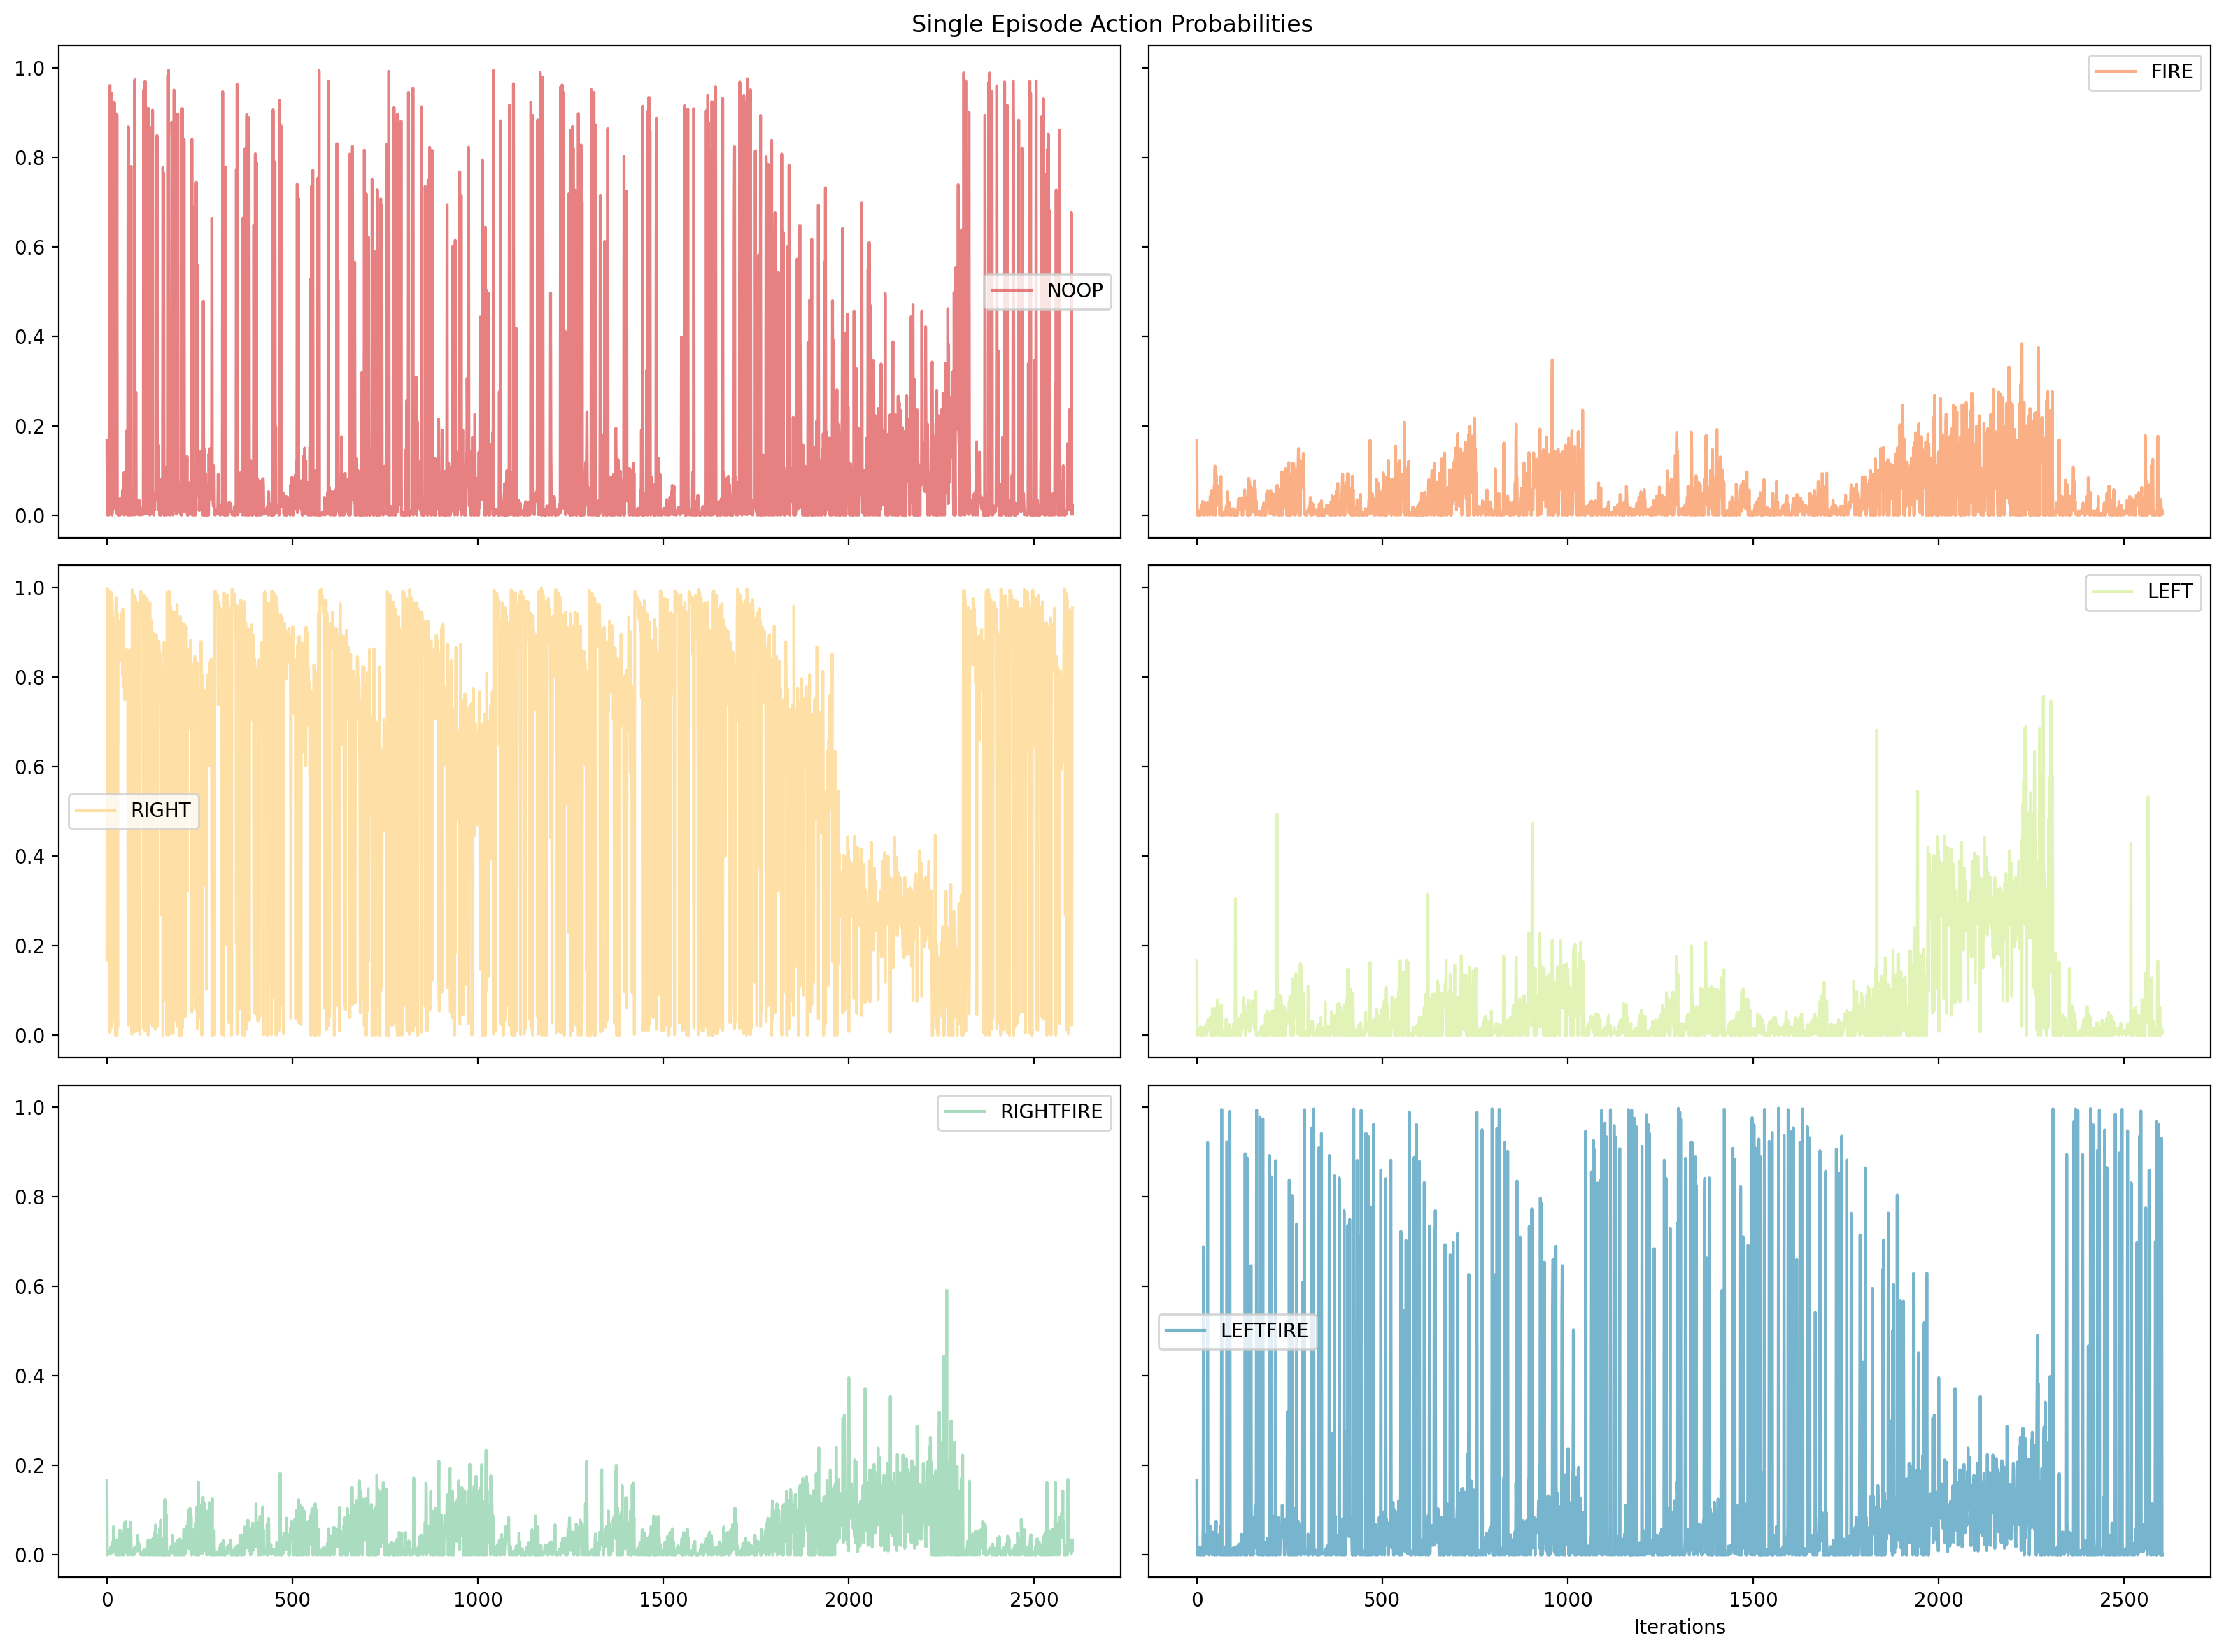

In [29]:
action_dict = {
    0 : 'NOOP',
    1 : 'FIRE',
    2 : 'RIGHT',
    3 : 'LEFT',
    4 : 'RIGHTFIRE',
    5 : 'LEFTFIRE'
}
def plot_probs(prob_list, eps_iters_list, batch_size, step=1):
    probs_arr = np.vstack(prob_list)
#     plt.figure(figsize=(16,5))
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,12), dpi=200, sharex=True, sharey=True)
    fig.suptitle('Single Episode Action Probabilities')
    colors = sns.color_palette('Spectral', 7)
    colors = colors[:3] + colors[4:]
    for i, (ax, color) in enumerate(zip(axs.flatten(), colors)):
        sns.lineplot(data=probs_arr[::step,i], color=color, label=action_dict[i], alpha=.7, dashes=False, ax=ax)
#     plt.xticks(np.asarray(plt.xticks(), dtype=np.int32) * step)
#     for i, eps_iters in enumerate(eps_iters_list):
#         plt.axvline(eps_iters, 0, 1, color='red' if not i % batch_size else 'pink')
    plt.xlabel('Iterations')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()
    return

if record_probs:
    plot_probs(prob_list, eps_iters_list, batch_size)

[120.0, 265.0]


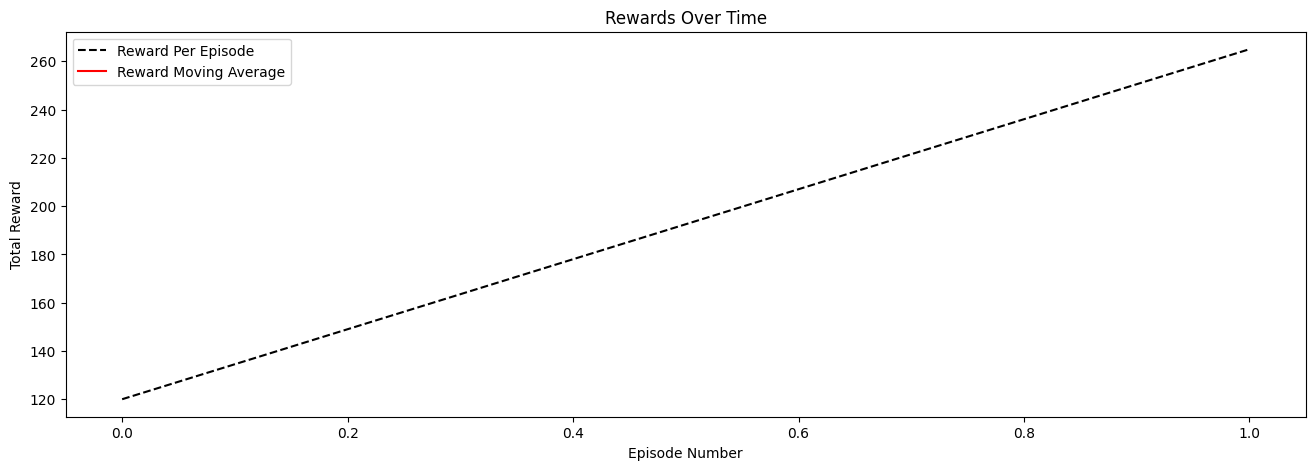

In [15]:
def moving_average(a, window_size) :
    ret = np.cumsum(a, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size

def plot_rewards(reward_list, window_size=10):
    plt.figure(figsize=(16,5))
    plt.title('Rewards Over Time')
    plt.ylabel('Total Reward')
    plt.xlabel('Episode Number')
    x = np.arange(0, len(reward_list), 1)
    assert len(x) == len(reward_list)
    plt.plot(x, reward_list, color='black', linestyle='dashed', label='Reward Per Episode')
    plt.plot(x[window_size-1:], moving_average(reward_list, window_size), color='red', label='Reward Moving Average')
    plt.legend()
    plt.show()
    return

print(reward_list)
if record_rewards:
    plot_rewards(reward_list, window_size=200)

In [16]:
# print(obs)
# show_obs(obs)
# pre_obs = preprocess(obs)
# show_obs(pre_obs.reshape(83,140))
# print(pre_obs)